<img align="center" src="https://www.quotemaster.org/images/6c/6cd4402a3a471df34ea4e9232fe6d3cd.jpg" width="350"> 


# Семинар 5: Регрессия - моя профессия!

Ура! Ура! Ура! Наконец-то пришло время заняться машинным обучением. Начнём с регрессии.



Сегодня мы будем сравнивать линейные модели со случайными лесами! В будущем вам редко придется сталкиваться с расчетами коэффициентов регрессий на бумажке, это довольно затруднительно, если у вас много наблюдений. Скореее к этому будут привлекаться аппартаные методы (в худшем случае exel). Но так как мы народ продвинутый, мы умеем обрабатывать данные и строить модельки используя python.

In [1]:
import pandas as pd               # уже знакомый вам пакет для работы с таблицами
import numpy as np                # смутно знакомый вам пакет для работы с матрицами
import matplotlib.pyplot as plt   # уже смутно знакомый вам пакет для картинок :3
import seaborn as sns             # ещё один пакет для картинок 
plt.style.use('ggplot')     # правильный (очень красивый) стиль у графиков

%matplotlib inline

# 1. Метрики в задаче регрессии

Мы решаем задачу регрессии. Нужно прогнозировать действительные числа. Качество прогнозов, которые мы делаем нужно оценивать с помощью какой-то метрики. В ручной части семинара мы обсудили с вами несколько метрик. Мы при решении задачи будем использовать MAE и RMSE.

In [2]:
from sklearn import metrics  # подгружаем метрики

y_test = [4,20,110]
y_pred = [5,10,100]

metrics.mean_absolute_error(y_test, y_pred)

7.0

In [3]:
np.sqrt(metrics.mean_squared_error(y_test, y_pred))

8.18535277187245

Давайте напишим небольшую функцию, с помощью которой нам будем немного удобнее выводить эти две метрики на экран.

In [4]:
def print_metrics(y_test,y_pred):
    print('MAE:', "%.4f" % metrics.mean_absolute_error(y_test, y_pred))
    print('RMSE:', "%.4f" % np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

print_metrics(y_test,y_pred)

MAE: 7.0000
RMSE: 8.1854


# 2. Данные

Мы будем предсказывать рейтинг видеоконтента на сайте IMDB по набору параметров. Загрузим же данные и посмотрим на них.

In [5]:
df = pd.read_csv('pimdb.csv', sep=',')    # подгружаем датасет
print('Размерность таблицы:', df.shape)   # shape показывает его размер
df.head()

Размерность таблицы: (14761, 10)


,Title,ImdbRating,RatingCount,Duration,Type,WinsCount,NominationsCount,PhotosCount,NewsArticlesCount,UserReviewsCount
0,der vagabund und das kind,8.4,40550.0,3240.0,video.movie,1.0,0.0,19.0,96.0,85.0
1,goldrausch,8.3,45319.0,5700.0,video.movie,2.0,1.0,35.0,NaN,122.0
2,metropolis,8.4,81007.0,9180.0,video.movie,3.0,4.0,67.0,428.0,376.0
3,der general,8.3,37521.0,6420.0,video.movie,1.0,1.0,53.0,123.0,219.0
4,lichter der gro stadt,8.7,70057.0,5220.0,video.movie,2.0,0.0,38.0,187.0,186.0


In [6]:
df.dtypes

Title                 object
ImdbRating           float64
RatingCount          float64
Duration             float64
Type                  object
WinsCount            float64
NominationsCount     float64
PhotosCount          float64
NewsArticlesCount    float64
UserReviewsCount     float64
dtype: object

## 2.1 Целевая переменная.

Прогнозировать будем рейтинг фильма. Посмотрим как он распределён. 

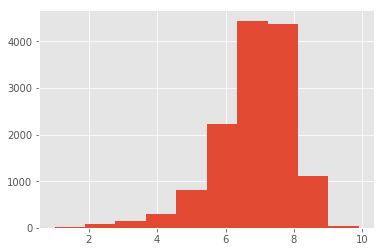

In [7]:
df.ImdbRating.hist();

## 2.2 Объясняющие переменные

Все переменные из таблички можно поделить на две части: непрерывные и категориальные. Делать их предобработку нужно по-разному. 

* непрерывные переменные принимают любые действительные значения
* категориальные принимают значения из ограниченного множества значений

Все эти переменные нужно предобрабатывать. Тут давайте остановимся и вспомним какие именно проблемы возникают с данными. Вам об этом рассказывали на лекциях. 


### Категориальные переменные 

Категориальная переменная у нас одна: `Type`. Она принимает $4$ различных значения.

In [8]:
df['Type'].value_counts()

video.movie      11072
video.episode     1979
video.tv          1591
game               119
Name: Type, dtype: int64

Отзыв оставляется либо на фильм, либо на серию, либо на передачу с TV либо на игру. Мы не можем отправить переменную в модель в таком виде. 

Алгоритмы умеют учиться на числах. Надо заменить все категории на числа. Вопрос в том, как бы это лучше сделать. Переменная принимает $4$ значения. Возникает соблазн заменить  все `video.movie` на 1, `video.episode` на 2, `video.tv` на 3, а `game` на 4. 

Это неправильный подход. Если так сделать, то некоторые алгоритмы могут подумать, что четвёртый тип самый лучший, а первый самый плохой. Очень большой вопрос, почему мы определили порядок категорий именно так. Это запутает алгоритм. 

Чтобы не путать алгоритм, поступают следующим образом: делают из категориальной переменной много дамми (принимают значения $1$ или $0$. Вот так:

In [9]:
dummies = pd.get_dummies(df['Type'])
dummies.head()

,game,video.episode,video.movie,video.tv
0,0,0,1,0
1,0,0,1,0
2,0,0,1,0
3,0,0,1,0
4,0,0,1,0


Если отзыв относится к типу `video.movie`, то у него в соответствующем столбце будет стоять единичка, а в остальных нули.

__Приятный бонус:__  Не нужно бороться с пропусками в переменных. Для пропусков будет своя дамми и мы не потеряем информации. Такой способ работы с категориями называется One Hot Encoding. Дословно можно перевести как одно горячее кодирование (это шутка такая, если вы так скажите какому-то аналитку, он сначала вас не поймёт, а потом, наверное, поугарает).

В чём минус одного горячего кодирования? Можно обжечься. Если категорий внутри переменной много, то мы переработаем её в слишком большое число столбцов. В конечном итоге это может привести к тому, что модели не хватит наблюдений, чтобы научиться в этом огромном числе столбцов ориентироваться.

Прикрепим полученные стоблцы к основной таблице с данными. Старый столбец удалим.

In [10]:
df = pd.concat([df, dummies], axis=1)
df.drop('Type', axis=1, inplace=True)
df.head()

,Title,ImdbRating,RatingCount,Duration,WinsCount,NominationsCount,PhotosCount,NewsArticlesCount,UserReviewsCount,game,video.episode,video.movie,video.tv
0,der vagabund und das kind,8.4,40550.0,3240.0,1.0,0.0,19.0,96.0,85.0,0,0,1,0
1,goldrausch,8.3,45319.0,5700.0,2.0,1.0,35.0,NaN,122.0,0,0,1,0
2,metropolis,8.4,81007.0,9180.0,3.0,4.0,67.0,428.0,376.0,0,0,1,0
3,der general,8.3,37521.0,6420.0,1.0,1.0,53.0,123.0,219.0,0,0,1,0
4,lichter der gro stadt,8.7,70057.0,5220.0,2.0,0.0,38.0,187.0,186.0,0,0,1,0


У нас осталась в датасете только одна нечисловая переменная, `Title`. Названия видео роликов в модели мы не будем использовать (во-первых это номинальная переменная, во-вторых ее нужно по-хитрому обрабатывать). Удалим её из данных. 

In [11]:
df.drop('Title', axis=1, inplace=True)

### Непрерывные переменные 

Пройдёмся по всем непрерывным переменным.  Как мы видим, длительность видео указана в секундах, что странно и не несет практической ценности. Давайте переведем ее в минуты.

In [12]:
df.loc[:,'Duration'] = df.Duration / 60

Давайте посмотрим на пропуски в наших данных

In [13]:
df.isnull().sum()

ImdbRating           1210
RatingCount          1210
Duration             1016
WinsCount              21
NominationsCount       11
PhotosCount            12
NewsArticlesCount       6
UserReviewsCount        1
game                    0
video.episode           0
video.movie             0
video.tv                0
dtype: int64

`ImdbRating` -  это целевая переменная, мы не можем ее оставить пустой, но и не можем заполнить ее какими-то заданными значениями, поэтому мы вырежем их из нашего датасета.

In [14]:
df.shape  # Размерность таблицы до удаления пропусков

(14761, 12)

In [15]:
df.dropna(subset=['ImdbRating'], inplace=True)

In [16]:
df.shape  # Размерность таблицы после удаления пропусков

(13551, 12)

Если выбросить ещё и оставшиеся пропуски, то мы потеряем целую $1000$ записей. 

In [17]:
df.dropna().shape

(12764, 12)

Чтобы не терять данные, заполним пропуски чем-нибудь. Например, нулями. Кстати говоря, почему так можно делать? Чем ещё можно заполнять пропуски? 

In [18]:
# ваш код
df = df.fillna(0)

Посмотрим как распределены переменные.

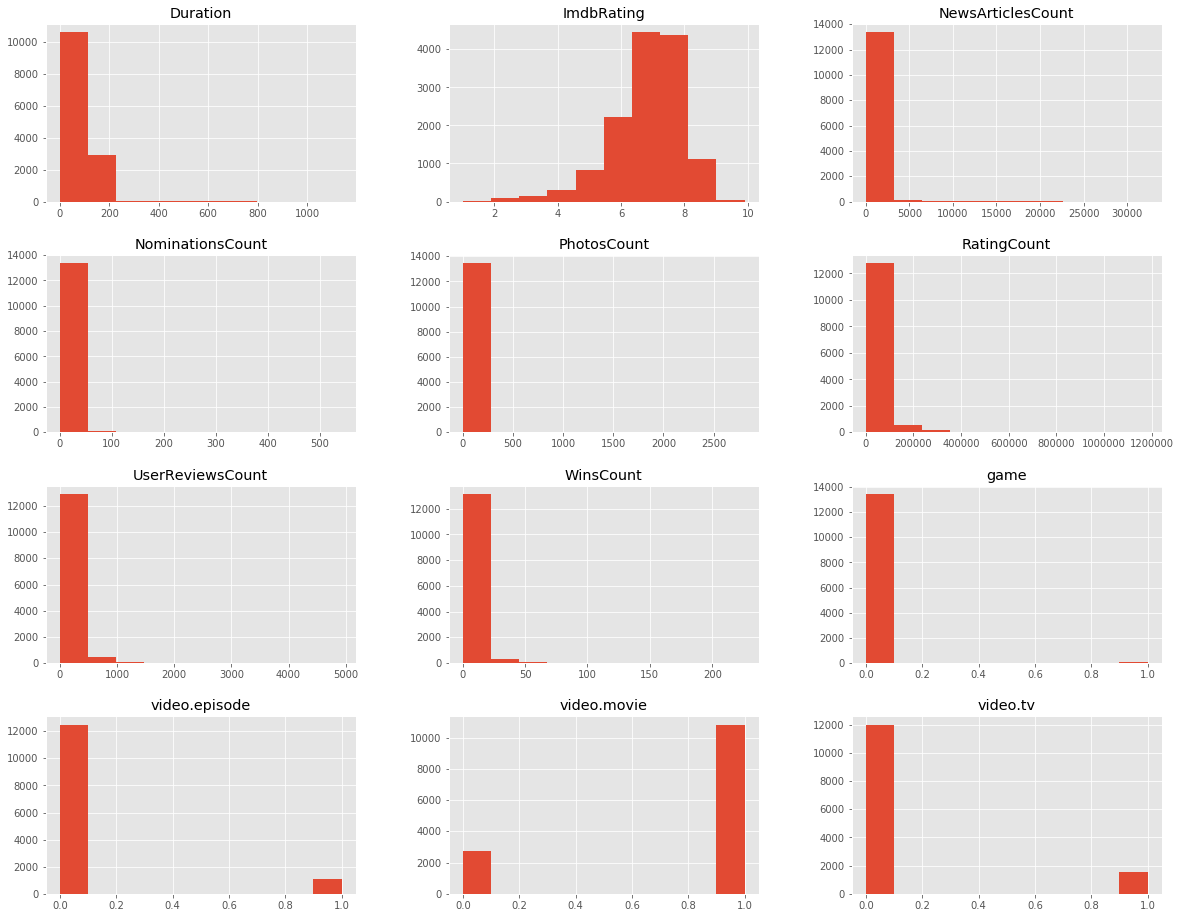

In [19]:
df.hist(figsize=(20,16));

Можно заметить, что в наших переменных-счетчиках есть тяжелые хвосты, которые мы можем победить логарифмированием. Кстати, чем нам не угодили тяжелыее хвосты? Что ещё можно было бы сделать с ними, кроме логарифмирования? 

In [20]:
# мы уже вытаскивали до этого счётчики из данных таким циклом
variables_cnt = [item for item in df.columns if item[-5:] == 'Count']

Берем логарифмы.

In [21]:
df[variables_cnt] = df[variables_cnt].apply(lambda w: np.log(w + 1))

# продолжительность тоже прологарифмируем из-за длинного хвоста 
df.loc[:,'Duration'] = df.Duration.apply(lambda w: np.log(w + 1))

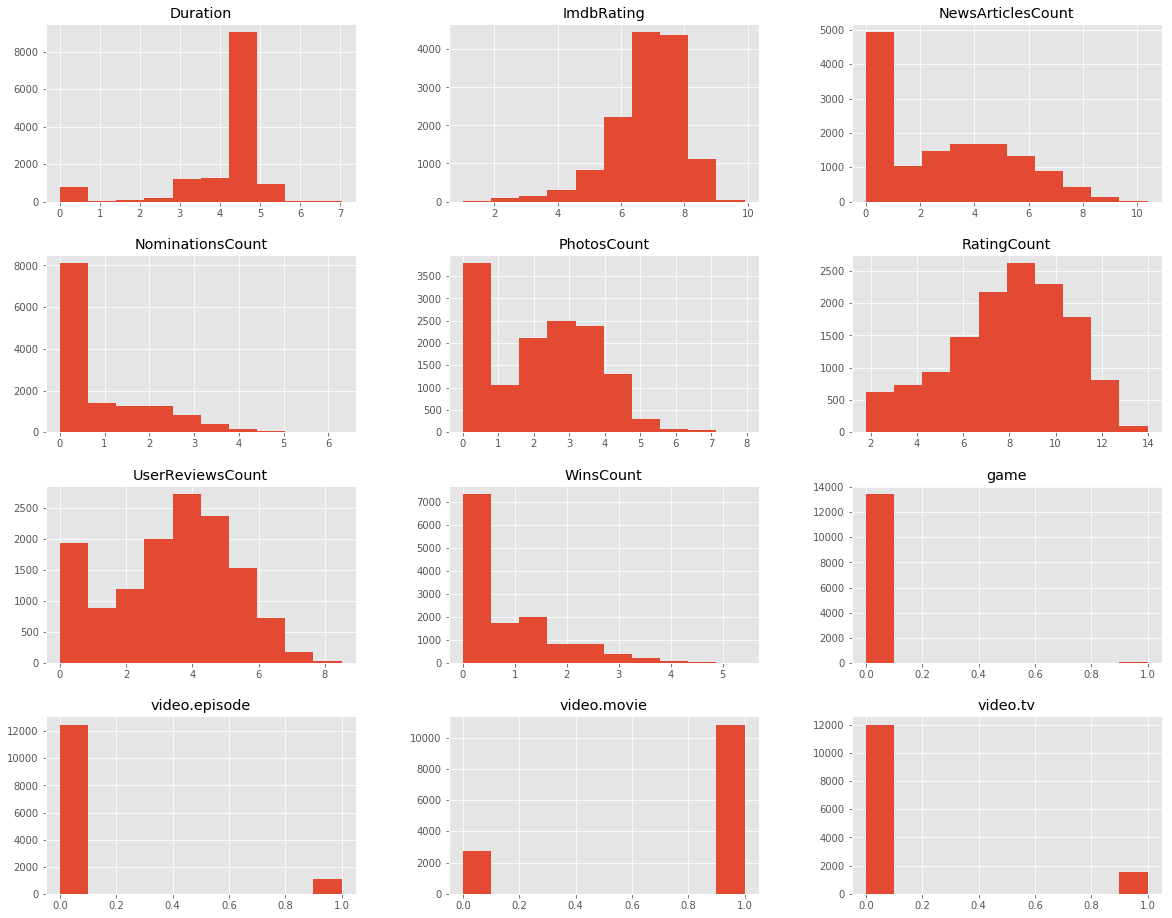

In [22]:
df.hist(figsize=(20,16));

Теперь у нас красивые и чистые данные, на которых мы можем строить модели. Так давайте строить!

# 3. Моделирование 

С чего мы начнем?

Правильно! Поделим выборку! Отрежем от нашей выборки 80%, которые будем использовать для обучения модели и 20%, на которых мы будем определять качество модели. Почему нельзя  тестировать качество модели на обучающей выборке?

In [23]:
from sklearn.model_selection import train_test_split  # функция для деления 

# делим в пропорции 80 к 20
df_train, df_test = train_test_split(df, test_size = 0.2, random_state=42)

Когда мы обучаем модель на тренировочных данных, нам хочется понять насколько хорошо она работает в боевых условиях. Выборка, на которой мы учимся, не подходит для этих целей. Так как знания об этих объектах уже будут лежать в нашей модели, а в реальной жизни будут встречаться и новые, ранее неизвестные объекты. 

Будем учить алгоритм только на тренировочной. Тогда при обучении алгоритм не увидит тестовые примеры. Значит можно использовать её для имитации этих самых новых объектов из реальной жизни и посмотреть какое на них будет качество.

In [24]:
y_train = df_train['ImdbRating'].to_numpy()
y_test = df_test['ImdbRating'].to_numpy()

X_train = df_train.drop('ImdbRating', axis=1).to_numpy()
X_test = df_test.drop('ImdbRating', axis=1).to_numpy()

feature_names = df_train.drop('ImdbRating', axis=1).columns

In [25]:
y_train

array([4.7, 7.8, 5.7, ..., 5.9, 7.4, 4.9])

In [26]:
X_train

array([[ 6.23441073,  4.59511985,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 9.2211814 ,  4.53259949,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [11.39204514,  4.72738782,  2.07944154, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [11.9766469 ,  4.88280192,  1.38629436, ...,  0.        ,
         1.        ,  0.        ],
       [11.15612194,  4.33073334,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [11.9009324 ,  4.77068462,  2.39789527, ...,  0.        ,
         1.        ,  0.        ]])

In [27]:
X_train.shape

(10840, 11)

## 3.1 Наивный прогноз 

Для начала не будем мудрить и посчитаем, какие значения принимают функции качества при использовании самой простой модели - средней оценки по рейтингу.

In [28]:
y_mean = np.mean(y_train)                     # посчитали среднее 
y_pred_naive = np.ones(len(y_test)) * y_mean  # спрогнозировали им лайки

Посмотрим насколько точный у нас прогноз. 

In [29]:
print_metrics(y_test, y_pred_naive)

MAE: 0.8460
RMSE: 1.1079


Что означают эти числа?

## 3.2  Линейная регрессия

А теперь давайте попробуем применить линейную регессию.

In [30]:
#Что хотим увидеть
from sklearn.linear_model import LinearRegression # подгрузили модель

# Объявили модель
model_regression = LinearRegression()

# Обучили модель на тренировочной выборке 
model_regression.fit(X_train, y_train)

# Сделали прогнозы на тестовой выборке 
y_pred_regr = model_regression.predict(X_test)

Посмотрим на метрики. 

In [31]:
print_metrics(y_test, y_pred_regr)

MAE: 0.7290
RMSE: 0.9913


Ошибки чуть-чуть упали, регрессия победила, можно расходиться (на самом деле нет). 

Посмотрим на то, какие признаки вносят в продажи наибольший вклад в прогноз.

In [32]:
model_regression.coef_  # коэффициенты модели

array([ 0.20026579,  0.05554393,  0.4393135 , -0.09389851, -0.04554165,
       -0.03771842, -0.18395314,  0.53589906,  0.39908074, -0.80347542,
       -0.13150439])

In [33]:
featureImportance = pd.DataFrame({"feature": feature_names,  "importance": model_regression.coef_})
featureImportance.head()

,feature,importance
0,RatingCount,0.200266
1,Duration,0.055544
2,WinsCount,0.439314
3,NominationsCount,-0.093899
4,PhotosCount,-0.045542


In [34]:
featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance.head()

,importance
feature,
game,0.535899
WinsCount,0.439314
video.episode,0.399081
RatingCount,0.200266
Duration,0.055544


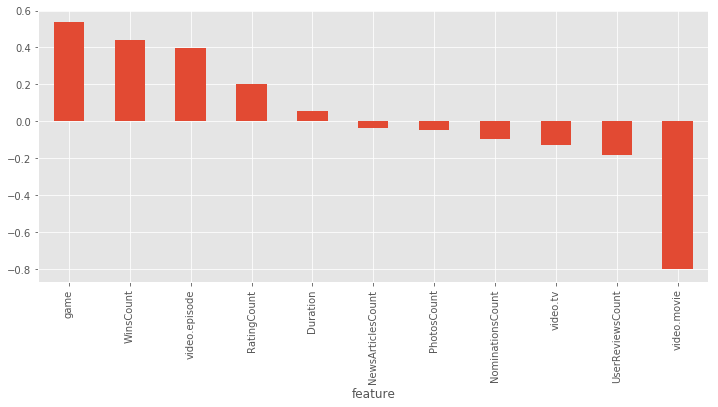

In [35]:
featureImportance["importance"][:15].plot(kind='bar', figsize=(12,5));

Что означают эти числа? Давайте проинтерпретируем то, что получилось. 

## 3.3  Случайный лес

Попробуем другую модель, о которой мы говорили на предыдущем семинаре: случайный лес. Что происходит при его обучении? 

In [36]:
# ваш код

Теперь посмотрим на метрику качества! 

In [1]:
# ваш код

Качество особо не увеличилось. 

# 4. Кросс-валидация 

Главная задача обучаемых алгоритмов – их способность обобщаться, то есть хорошо работать на новых данных. Поскольку на новых данных мы сразу не можем проверить качество построенной модели (нам ведь надо для них сделать прогноз, то есть истинных значений целевого признака мы для них не знаем), то надо пожертвовать небольшой порцией данных, чтоб на ней проверить качество модели. Чаще всего это делается одним из 2 способов:


* отложенная выборка __(held-out/hold-out set).__ При таком подходе мы оставляем какую-то долю обучающей выборки (как правило от 20% до 40%), обучаем модель на остальных данных (60-80% исходной выборки) и считаем некоторую метрику качества модели. Сейчас мы сделали именно так. У этого подхода есть минусы. Результат работы модели может сильно зависеть от конкретного разбиения. Хочется убить эту зависиомсть. Для этого используют кросс-валидацию. 

* кросс-валидация __(cross-validation, на русский еще переводят как скользящий или перекрестный контроль).__ Тут самый частый случай – K-fold кросс-валидация



<img src="https://hsto.org/files/b1d/706/e6c/b1d706e6c9df49c297b6152878a2d03f.png" height="600" width="600"> 


Модель обучается $K$ раз на разных подвыборках исходной выборки (белый цвет), а проверяется на одной подвыборке (каждый раз на разной, оранжевый цвет). Получаются $K$ оценок качества модели, которые обычно усредняются, выдавая среднюю оценку качества классификации/регрессии на кросс-валидации. 

Кросс-валидация дает лучшую, по сравнению с отложенной выборкой, оценку качества модели на новых данных. Но кросс-валидация вычислительно дорогостоящая, если данных много.
 
Кросс-валидация – очень важная техника в машинном обучении, с ее помощью выбираются гиперпараметры моделей, сравниваются модели между собой, оценивается полезность новых признаков в задаче и т.д.

In [38]:
# для такой стратегии используем всю выборку, так как разбиение делаем на каждом шаге заново

y = df['ImdbRating'].to_numpy()
X = df.drop('ImdbRating', axis=1).to_numpy()

Посмотрим на качество линейной регрессии по кросс-валидации. 

In [39]:
from sklearn.model_selection import cross_val_score

model = LinearRegression()

cv_linear_reg_results = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_linear_reg_results

array([-0.78948324, -0.94298088, -1.14740829, -1.09960619, -1.24345578])

In [40]:
np.mean(np.sqrt(-1*cv_linear_reg_results))

1.0188993506815518

Теперь то же самое для случайного леса. 

In [2]:
# ваш код

Лидирует регрессия. Но погодите, сколько у нас деревьев в лесу? А какой высоты? А листья у нас какого размеа? Так мы не настроили параметры! Пора это исправлять.

# 5. Grid search (поиск по решётке) 

Можно, конечно, назначить параметры экспертно и просто подставить свои любимые числа, но в этом случае качество модели будет определяться довольно рандомно. В жизни случаются счастливые случайности, но давайте попробуем выбрать лучшие гиперпараметры модели на какой-нибудь сетке параметров.

Давайте посмотрим, какие гиперпараметры мы используем сейчас.

In [43]:
print(reg_forest.get_params())

{'bootstrap': True, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


Пропишем сетку для перебора параметров.

In [44]:
param_grid = [
    { 
        'criterion': ['mse', 'mae'],
        'n_estimators': range(1, 31, 10)
    }
]

Для начала по-прежнему возьмем нашу тренировочную выборку, которую мы приготовили чуть раньше, и приготовимся по ней проводить кросс-валидацию и подбирать параметры. 

In [45]:
from sklearn.model_selection import GridSearchCV

model = RandomForestRegressor( )

grid_cv = GridSearchCV(model, 
                       param_grid, 
                       scoring='neg_mean_absolute_error', 
                       cv=5)

In [46]:
grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'criterion': ['mse', 'mae'],
 

Давайте посмотрим на  гиперпараметры, которые мы получили.

In [47]:
grid_cv.best_params_

{'criterion': 'mae', 'n_estimators': 21}

In [48]:
grid_cv.best_score_ # качество на кросс-валидации по X_train

-0.7205899666139519

In [49]:
grid_cv.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=21,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

Модель применяем к тестовой выборке и сравниваем.

In [50]:
y_reg_tree_greed_pred = grid_cv.predict(X_test)

In [51]:
print_metrics(y_test, y_reg_tree_greed_pred)

MAE: 0.6927
RMSE: 0.9612


Давайте попробуем потюнить еще несколько параметров модели случайного леса, например наибольшую глубину: ` 'max_depth': range(3, 7),`

In [3]:
# Ваш код

Какие выводы делаем? 

# 6. Визуализации и результаты

Теперь давайте визуализируем прогнозы. По оси $x$ отложены рельные значения рейтинга, по оси $y$ отложены прогнозы. Если модель работает хорошо, прогноз должен совпадать с реальным значением и наши точки на обоих картинках должны выстроиться вдоль диагонали.

In [54]:
def plot_yreal_ypred(y_test, y_train, X_test, X_train, model, margin=0.3):
    """
        Рисует картинку для прогнозов
            modelt - модель 
            y_train, X_train - обучающая выборка
            y_test, X_test - тестовая выборка
            margin - граница рисунка 
    """
    
    plt.figure(figsize=(16,7))
    plt.subplot(121)
    plt.scatter(y_train, model.predict(X_train), color="red", alpha=0.1)
    plt.xlim(min(y_train) - margin, max(y_train) + margin)
    plt.ylim(min(y_train) - margin, max(y_train) + margin)
    plt.title('Train set', fontsize=20)
    plt.xlabel('y', fontsize=14)
    plt.ylabel('Estimated y', fontsize=14)

    plt.subplot(122)
    plt.scatter(y_test, model.predict(X_test), color="red", alpha=0.1)
    plt.xlim(min(y_test) - margin, max(y_test) + margin)
    plt.ylim(min(y_test) - margin, max(y_test) + margin)
    plt.title('Test set', fontsize=20)
    plt.xlabel('y', fontsize=14)
    plt.ylabel('Estimated y', fontsize=14)
    pass

Любители ассоциативной психологии могут поискать тут силуэты, но как мы видим, и на обучении и на тесте мы не получили хорошего качества предсказания.

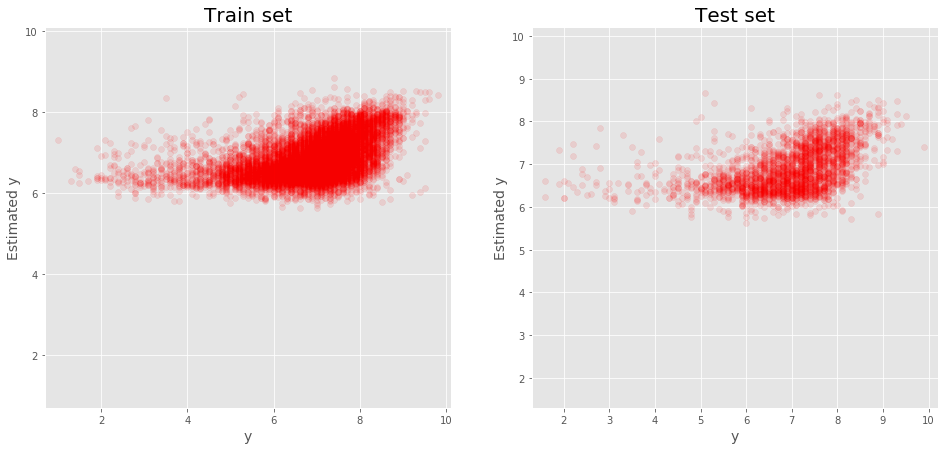

In [55]:
plot_yreal_ypred(y_test, y_train, X_test, X_train, model_regression)

В модели случайного леса на тесте мы добились очень неплохих результатов на обучающей выборке, а на тестовой по-прежнему все плохо. Как же так получилось? 

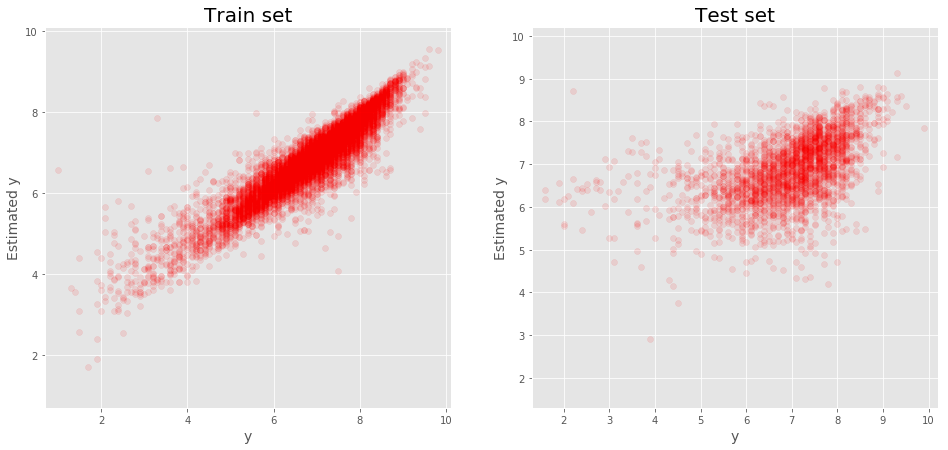

In [56]:
plot_yreal_ypred(y_test, y_train, X_test, X_train, reg_forest)

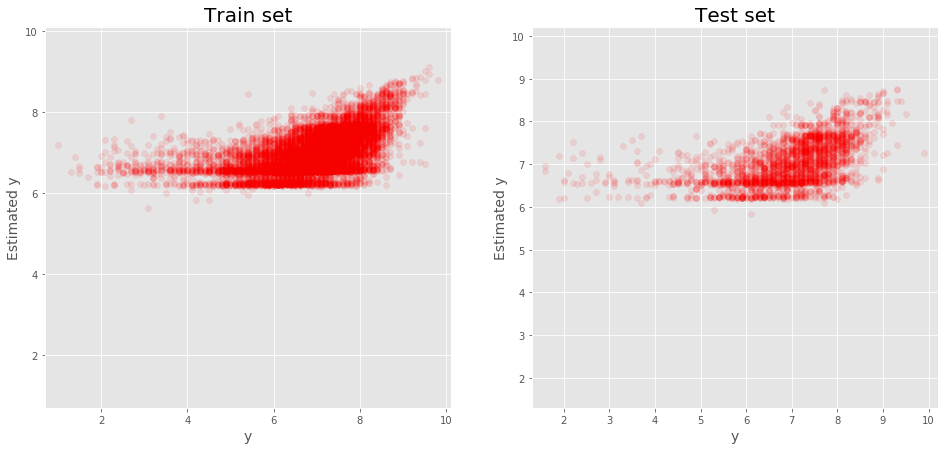

In [57]:
plot_yreal_ypred(y_test, y_train, X_test, X_train, grid_cv)

Давайте посмотрим теперь на ещё две картинки. Если бы мы построили хорошую модель, то на картинке она бы выглядела как-то вот так:
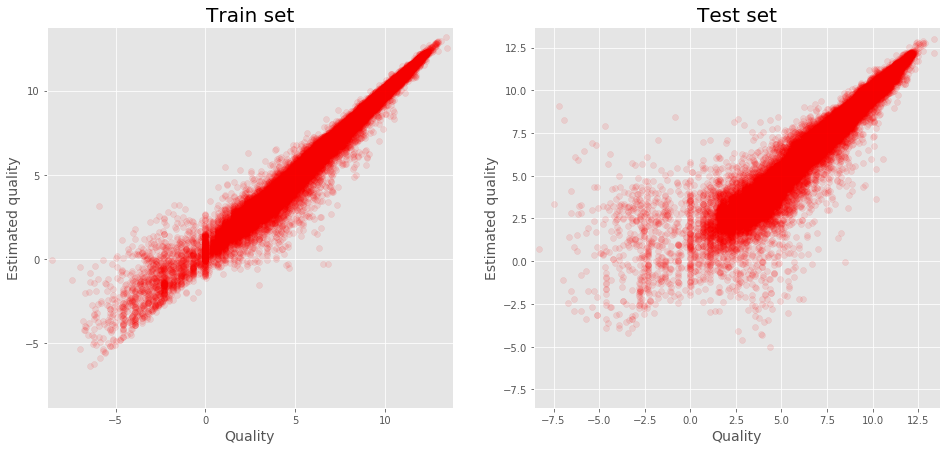

Видите? На тренировчной и на тестовой выборке точки довольно сильно вытянуты вдоль диагонали. Если мы видим такую картину, значит модели удалось вычленить из данные довольно много полезных закономерностей, и прогнозы строятся хорошо.

Вопрос на засыпку: а что, если облако на тренировочной выборке оказывается вытянутым, а на тестовой выборке оказывается толстым? Давайте вспомним нашу модель случайного леса без параметров:
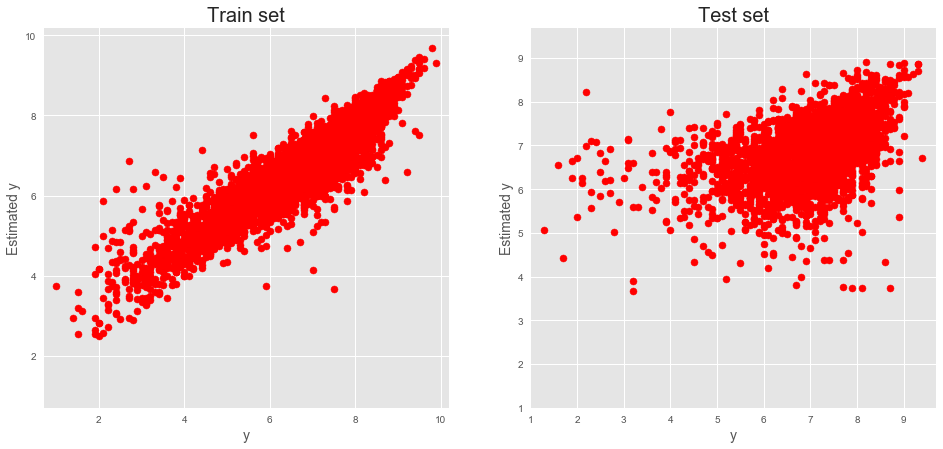

Что мы видим на ней? На тренировочной выборке наши прогнозы близки к идеальным, а на тестовой выборке они ужасные и даже близко к диагонали не лежат. Что это означает? Это означает, что мы переобучились. Мы хорошо научились ориентироваться в каких-то частных особенностях тренировочной выборки и строить прогнозы для неё. Но то, что мы запомнили эти частные особенности, никак нам не помогает хорошо прогнозировать $y$ для ноовых объектов. То есть модель оказывается бесполезной.